In [1]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [2]:
%cd gdrive/My Drive/test_colab/ml_project2/src

/content/gdrive/My Drive/test_colab/ml_project2/src


In [3]:
!git reset --hard
!git pull

Checking out files: 100% (559/559), done.
HEAD is now at f5aa47c import error
remote: Enumerating objects: 7, done.
remote: Counting objects: 100% (7/7), done.
remote: Compressing objects: 100% (1/1), done.
remote: Total 4 (delta 3), reused 4 (delta 3), pack-reused 0
Unpacking objects: 100% (4/4), done.
From https://github.com/salimbeni1/ml_project2
   f5aa47c..e289fdb  main       -> origin/main
Updating f5aa47c..e289fdb
Fast-forward
 src/utils.py | 15 +++++++++++++++
 1 file changed, 15 insertions(+)


In [4]:
import sound_processing as sp
import utils as ut
import numpy as np
from scipy import signal
from scipy.io import wavfile
import matplotlib.pyplot as plt
import glob

In [5]:
features, diseases, positions, controls, frequences, patientnbs = sp.get_feature_and_labels( '../data/train/*/*/*/'  ) # both control and case

indx = 100 # example on sample nb100
print(features[indx].shape ,diseases[indx] , positions[indx] , controls[indx] , frequences[indx] , patientnbs[indx])

100%|██████████| 532/532 [04:20<00:00,  2.04it/s]

(2, 110250) Pn P6 Ca 22050 29


In [6]:
featuresT, diseasesT, positionsT, controlsT, frequencesT, patientnbsT = sp.get_feature_and_labels( '../data/test/*/*/*/'  ) # both control and case

indx = 2 # example on sample nb100
print(featuresT[indx].shape ,diseasesT[indx] , positionsT[indx] , controlsT[indx] , frequencesT[indx] , patientnbsT[indx])

100%|██████████| 70/70 [00:49<00:00,  1.42it/s]

(4, 110250) Pn P3 Ca 22050 30


In [7]:
import keras
from keras.models import Sequential
from keras.layers import Dense, Convolution2D, Flatten, MaxPooling2D, ZeroPadding2D, Dropout, BatchNormalization, Activation
from keras import optimizers
from keras.utils import to_categorical
from keras.preprocessing.image import ImageDataGenerator
from keras.models import load_model
from keras.callbacks import ModelCheckpoint, CSVLogger, RemoteMonitor, TensorBoard, ReduceLROnPlateau
from tensorboardcolab import TensorBoardColab, TensorBoardColabCallback

In [9]:
#position = 'P5'
#indx = positions == position
indx = range(positions.shape[0])

x_train, y_train, pnb_train, pos_train = ut.prepare_samples(features[indx],controls[indx],positions[indx],patientnbs[indx])
print(x_train.shape, y_train.shape)

shuffleling
(5894, 150, 216, 1) (5894, 2)


In [10]:
#position = 'P5'
#indx = positionsT == position
indx = range(positionsT.shape[0])

x_test, y_test, pnb_test, pos_test = ut.prepare_samples(featuresT[indx],controlsT[indx],positionsT[indx],patientnbsT[indx])
print(x_test.shape, y_test.shape)

shuffleling
(1256, 150, 216, 1) (1256, 2)


In [11]:
shape = x_train.shape[1:]
train_batch_size = 32
train_steps = x_train.shape[0]//train_batch_size # need to specify the number of steps since the data generator outputs continuously

train_generator = ImageDataGenerator(width_shift_range=20,
                            #height_shift_range=4,
                            #zoom_range=[1/1.3, 1.3],                            
                            )


train_generator.fit(x_train) #apply the augmetnation to train data

train_datagen = train_generator.flow(x_train, y_train, batch_size=train_batch_size) # creates the mii batch flow

In [12]:
model = Sequential()

model.add(Convolution2D(20, (3, 3), activation='relu', padding='same', input_shape=shape))
model.add(BatchNormalization())
model.add(MaxPooling2D(2, 2))
model.add(Dropout(0.25))

model.add(Convolution2D(50, (3, 3), activation='relu', padding='same', input_shape=shape))
model.add(BatchNormalization())
model.add(MaxPooling2D(2, 2))
model.add(Dropout(0.25))

model.add(Flatten())
dense1_unit = 25
model.add(Dense(dense1_unit, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.5))

model.add(Dense(2, activation='softmax'))

sgd = optimizers.SGD(lr=0.00004, decay=1e-6, momentum=0.9, nesterov=True)

model.compile(optimizer=sgd, loss='binary_crossentropy', metrics=['accuracy',ut.f1])                        

In [19]:
#### Callbacks
checkpointer = ModelCheckpoint(monitor='val_accuracy', # automatically saves the model 
                               mode='auto', 
                               filepath='../XXX.h5',
                               verbose=1,
                               save_best_only=True,
                               save_freq = 'epoch'
                              )
                            

csv_logger = CSVLogger('../XXX.txt') # saves the output log in csv


lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, # can be used to reduce the learning rate once the model stops learning
                       min_delta=0.001, cooldown=1,
                       verbose=1, patience=10,
                       min_lr=4.0e-5
                       )

#### Fit
history = model.fit_generator(train_datagen,
                              steps_per_epoch=train_steps,
                              epochs=10,
                              validation_data=(x_test, y_test),
                              #callbacks= [checkpointer]
                              )

Epoch 1/10
184/184 [==============================] - 15s 83ms/step - loss: 0.5791 - accuracy: 0.7320 - f1: 0.7317 - val_loss: 0.4214 - val_accuracy: 0.8065 - val_f1: 0.8078
Epoch 2/10
184/184 [==============================] - 15s 83ms/step - loss: 0.5476 - accuracy: 0.7371 - f1: 0.7346 - val_loss: 0.4057 - val_accuracy: 0.8296 - val_f1: 0.8305
Epoch 3/10
184/184 [==============================] - 15s 83ms/step - loss: 0.5116 - accuracy: 0.7566 - f1: 0.7576 - val_loss: 0.4223 - val_accuracy: 0.8129 - val_f1: 0.8141
Epoch 4/10
184/184 [==============================] - 15s 83ms/step - loss: 0.4958 - accuracy: 0.7610 - f1: 0.7606 - val_loss: 0.3903 - val_accuracy: 0.8424 - val_f1: 0.8430
Epoch 5/10
184/184 [==============================] - 15s 83ms/step - loss: 0.5030 - accuracy: 0.7593 - f1: 0.7582 - val_loss: 0.4263 - val_accuracy: 0.8264 - val_f1: 0.8273
Epoch 6/10
184/184 [==============================] - 15s 82ms/step - loss: 0.4864 - accuracy: 0.7615 - f1: 0.7611 - val_loss: 0.4

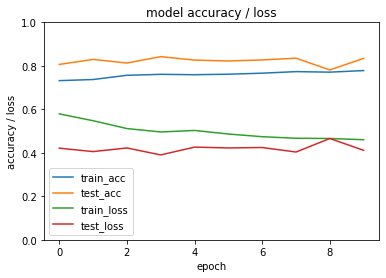

In [20]:
ut.plot_history(history)

In [15]:
for pos in range(8):
  model.load_weights('../P'+str(pos+1)+'_D25.h5')
  print('Pos'+str(pos+1),model.evaluate(x_test, y_test))

40/40 [==============================] - 1s 13ms/step - loss: 0.5313 - accuracy: 0.7381 - f1: 0.7406
Pos1 [0.5312676429748535, 0.7380573153495789, 0.7406249642372131]
40/40 [==============================] - 1s 13ms/step - loss: 0.5510 - accuracy: 0.7970 - f1: 0.7984
Pos2 [0.5510334968566895, 0.7969745397567749, 0.7984374761581421]
40/40 [==============================] - 1s 13ms/step - loss: 0.4869 - accuracy: 0.8209 - f1: 0.8219
Pos3 [0.4868663251399994, 0.8208598494529724, 0.8218749165534973]
40/40 [==============================] - 1s 13ms/step - loss: 0.4806 - accuracy: 0.8272 - f1: 0.8281
Pos4 [0.48064547777175903, 0.8272293210029602, 0.8281248807907104]
40/40 [==============================] - 1s 13ms/step - loss: 0.6951 - accuracy: 0.7930 - f1: 0.7922
Pos5 [0.6950857043266296, 0.7929936051368713, 0.792187511920929]
40/40 [==============================] - 1s 13ms/step - loss: 0.5611 - accuracy: 0.8312 - f1: 0.8297
Pos6 [0.5611409544944763, 0.831210196018219, 0.8296874761581421]

In [16]:
x_test_ = x_test.copy()
y_test_ = y_test.copy()
p_test_ = pnb_test .copy()
pos_test_ = pos_test.copy()

print(x_test_.shape,y_test_.shape,p_test_.shape,pos_test_.shape)

(1256, 150, 216, 1) (1256, 2) (1256,) (1256,)


In [17]:
print(np.unique(patientnbsT))
unique_patient = np.unique(p_test_)

['12' '14' '18' '30' '40' '43' '46' '65' '7']


In [18]:
position_weights = [1,1,1,1,1,1,1,1]

y_pred_patient = []
y_expc_patient = []

for patient in unique_patient:
  x_test_patient = x_test_[p_test_ == patient]
  y_test_patient = y_test_[p_test_ == patient][0] # all the same
  pos_test_patient = pos_test_[p_test_ == patient]

  pred_patient = []
  print(np.unique(pos_test_patient))
  for pos in np.unique(pos_test_patient):
    model.load_weights('../'+str(pos)+'_D25.h5')
    pred = model.predict(x_test_patient[pos_test_patient == pos])
    for i in range(position_weights[int(pos[1])-1]):
      pred_patient.append(np.mean(pred,axis=0))
    
  y_pred_patient.append(np.mean(pred_patient,axis=0))
  y_expc_patient.append(y_test_patient)
  print('patient',patient ,' predicted:', np.mean(pred_patient,axis=0) , 'expected:' , y_test_patient)

y_pred_patient = np.array(y_pred_patient)
y_expc_patient = np.array(y_expc_patient)

['P1' 'P2' 'P3' 'P4' 'P5' 'P6' 'P7' 'P8']
patient 12  predicted: [0.8468406 0.1531593] expected: [1. 0.]
['P1' 'P2' 'P3' 'P4' 'P5' 'P6' 'P7' 'P8']
patient 14  predicted: [0.8046738  0.19532621] expected: [1. 0.]
['P1' 'P2' 'P3' 'P4' 'P5' 'P6' 'P7' 'P8']
patient 18  predicted: [0.8813555  0.11864445] expected: [1. 0.]
['P1' 'P2' 'P3' 'P5' 'P6' 'P7' 'P8']
patient 30  predicted: [0.12579393 0.87420607] expected: [0. 1.]
['P1' 'P2' 'P3' 'P4' 'P5' 'P6' 'P7' 'P8']
patient 40  predicted: [0.03155669 0.96844333] expected: [0. 1.]
['P1' 'P2' 'P3' 'P4' 'P5' 'P6' 'P7']
patient 43  predicted: [0.02664859 0.9733514 ] expected: [0. 1.]
['P1' 'P2' 'P3' 'P4' 'P5' 'P6' 'P7' 'P8']
patient 46  predicted: [0.01906963 0.9809303 ] expected: [0. 1.]
['P1' 'P2' 'P3' 'P4' 'P5' 'P6' 'P7' 'P8']
patient 65  predicted: [0.6810904  0.31890965] expected: [0. 1.]
['P1' 'P2' 'P3' 'P4' 'P5' 'P6' 'P7' 'P8']
patient 7  predicted: [0.80097765 0.19902232] expected: [1. 0.]
